# 2 Dimensional Path of a Projectile Simulation

The path of a projectile is an interesting, important, and sometimes challenging problem. It’s very likely
that you will have studied the path of a projectile in the absence of atmospheric drag in basic mechanics,
since this can be derived analytically. In the real world, however, drag can significantly alter the
trajectory. Unfortunately, in introducing this effect, we lose the ability to analytically obtain solutions
for the projectile’s trajectory: simulating the trajectory is therefore required. In this assignment, you
will write a Python program that computes trajectories under the influence of drag, and use this to
solve a simple targeting problem.

## Theory

We will neglect any crosswind effects, so that the projectile travels in a two-dimensional plane with
coordinates (x, y). The projectile’s position, velocity and acceleration can therefore be represented
as vector functions of time, which we denote by r(t) = [rx(t), ry(t)], v(t) = [vx(t), vy(t)] and a(t)
respectively. As the projectile travels through space, we will assume that it experiences two forces:
acceleration due to gravity, and a drag force Fd acting in the direction opposite to its trajectory. A free
body diagram of this scenario can be found in figure 1. The drag force can be roughly approximated
by the drag coefficient cd through the relationship

$$ Fd = 1/2 ρcdA|v|v,$$

which also involves the velocity v, air density ρ and the frontal area A (i.e. the two-dimensional cross-
section exposed to the drag force). cd is dimensionless and is used to quantify the drag of an object in

a fluid: the lower the value, the lower the drag force.
To simulate the trajectory of the projectile, we can use Newton’s second law:

$$F = ma ⇒ a(t) = 1/m(−1/2 ρcdA|v|v − mg)$$

where m is the mass of the projectile and g = (0, g) is acceleration due to gravity with g = 9.81 ms−2
.

Since we are interested in the projectile’s trajectory r, we can then utilise the fact that

$$a(t) = dv/dt = v ̇(t) and v(t) = dr/dt $$= r ̇(t)

to give us a ordinary differential equation:

$$r ̈(t) = 1m − 1/2 ρcdA|r ̇|r ̇ − mg$$

Notice that this is a non-linear equation that cannot be solved analytically – we therefore need a
computer to simulate it. It is also second-order: that is, it depends on the second derivative of r.
All that is left to do is equip the above with an appropriate set of initial conditions at time t = 0: we
will imagine that the projectile is fired from an initial starting height h at an angle of α degrees and
initial speed (velocity magnitude) v0, which gives:

$$ r(0) = (0, h) and r ̇(0) = v(0) = [v0 cos(πα/180), v0 sin(πα/180)] $$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import doctest
from scipy.optimize import minimize , differential_evolution

# Drag ODE Solver

Takes inputs of x and y velocity and x and y position [vx , vy , rx , ry]
    Returns [ax , ay , vx , vy]
    Outputs are the derivatives of the input values

    r = position
    v = velocity
    a = acceleration

    >>> drag_ode([1 , 1 , 1 , 1] , 1)
    [-0.000592493780917699, -9.810592493780918, 1, 1]

In [2]:
def drag_ode(y , t):
    
    #Defining constant parameters for projectile
    
    r=0.05                                      #Radius
    rho=1.225                                   #Density
    cd=0.479                                    #Drag Coef
    m=5.5                                       #Mass
    g=9.81                                      #Gravitational Constant
    A=math.pi*(r**2)                            #Surface Area
    magy = math.sqrt(y[0]**2 + y[1]**2)         #Velocity Magnitude    
    
    return([
    (-0.5 * rho * cd * A * magy * y[0])/m,
    (-0.5 * rho * cd * A * magy * y[1] - m*g)/m,
    y[0],
    y[1]
    ])

# Euler Solver 

Resolves drag_ode for these inputted initial conditions using an itterative Euler aproach
    Takes inputs of initial conditions initial velocity, angle, height and timestep
    Output in the form of an array with [t , vx , vy , rx , ry] at each timestep

    r = position
    v = velocity

In [3]:
def solve_ode_euler(v0 , a , h , tstep , max_t = 1000.0):
    if v0<100 or v0>800 or a<10 or a>80 or h<0 or tstep<0:
        raise ValueError ('Invalid input for solve_ode_euler')
    
    #Initializing at t=0
    y = [v0*math.cos(math.radians(a)) , v0*math.sin(math.radians(a)) , 0 , h]
    t = 0
    results = np.array([t] + y)
    
    #Itterating through number of timesteps
    for i in range(int(max_t/tstep)):
        ydot = drag_ode(y , t)
        y,t = y + np.array(ydot)*tstep , t + tstep          #Euler aproximation of next time step

        result = np.insert(y , 0 , t)
        results = np.vstack([results , result])

        if y[3] < 0:                                        #Break out of loop once negative ry value is reached
            break

    return(results)

# SciPy ODE Solver

Uses odeint function from scipy to generate solution to drag_ode
    Takes inputs of initial conditions initial velocity, angle, height and timestep
    Output in the form of an array with [t , vx , vy , rx , ry] at each timestep

    r = position
    v = velocity

In [4]:
def solve_ode_scipy(v0 , a , h , tstep , max_t = 1000):
    
    if v0<100 or v0>800 or a<10 or a>80 or h<0 or tstep<0:
        raise ValueError ('Invalid input for solve_ode_scipy')



    #Initializing time and initial conditions
    t=np.array_split(np.linspace(0 , max_t , int(max_t/tstep)), 50)
    vx=v0*math.cos(math.radians(a))
    vy=v0*math.sin(math.radians(a))
    rx=0
    ry=h
    results=np.empty((0,5),int)

    for row in t:                                           #Itterate over timestep sub arrays
        y=odeint(drag_ode , [vx , vy , rx , ry] , row)      #Solve for timesteps using odeint
        vx,vy,rx,ry = y[-1,0],y[-1,1],y[-1,2],y[-1,3]

        results = np.append(results , np.append(np.array_split(row,len(row)),y,axis=1)[0:-1] , axis=0)

        if ry < 0:      #Break loop when particle position becomes negative
            break

    results = results[results[:,4]>=0,:]    #Remove rows from results containing negative ry values

    return(results)

# Calling Functions To Compare With/Without Effects of Drag


Enter v0: 100
Enter angle of attack [deg]: 40
Enter an initial height: 30
travel time:  12.70190233193943
distance travelled:  801.0692247432326
maximum height:  212.48077788583862


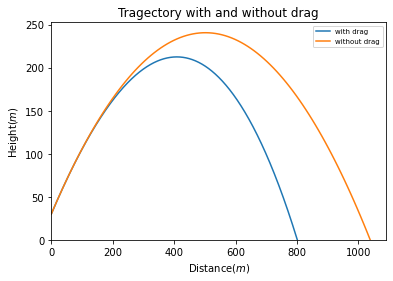

In [5]:
if __name__ == '__main__' :

    doctest.testmod()

    while True:
        try:
            #Taking user inputs
            v0 = float(input('Enter v0: '))
            a = float(input('Enter angle of attack [deg]: '))
            h = float(input('Enter an initial height: '))

            #Calculating travel time without drag to calculate appropriate timestep
            d = (v0*math.cos(math.radians(a))/9.81)*(v0*math.sin(math.radians(a)) + math.sqrt((v0*math.sin(math.radians(a)))**(2)+(2*9.81*h)))
            time = d/(v0*math.cos(math.radians(a)))
            tstep = time/1000        #Generate timestep based of travel time without drag

            #Resolving trajectory with drag using Euler
            res = solve_ode_euler(v0 , a , h , tstep)

            #Defining coordinates to be plotted
            x = res[:,3]
            y = res[:,4]

            #X and Y coordinates to be interpolated
            y1 = res[-2,4]
            y2 = res[-1,4]
            x1 = res[-2,3]
            x2 = res[-1,3]

            dist = x1 + (((x2-x1)/(y1-y2))*y1) #Interpolate to find x coordinate at y = 0

            print('travel time: ' , res[-1,0])
            print('distance travelled: ' , dist)
            print('maximum height: ' , max(res[:,4]))

            #Plot trajectory with drag
            plt.plot(x , y , label='with drag')

            #Array of x and y positions without drag
            xpos = np.linspace(0 , d , 100)
            ypos = h + xpos*math.tan(math.radians(a)) - (9.81*xpos**2)/(2*(v0*math.cos(math.radians(a)))**2)

            #Plot trajectory without drag
            plt.plot(xpos , ypos , label='without drag')
            plt.legend(loc=1 , prop={'size':7})
            plt.title('Tragectory with and without drag')
            plt.xlabel('Distance' + r'($m$)')
            plt.ylabel('Height' + r'($m$)')
            plt.xlim(0 , d*1.05)
            plt.ylim(0 , max(ypos)*1.05)
            plt.savefig('drag.pdf')
            plt.show()
            break

        except ValueError:
            print('Sorry please enter a valid set of values \nPlease enter velocities between 100 and 800 m/s and angles between 10 and 80 degrees')


# Part 2 - Projectile Targeting Optimization

In your second file, target.py, you should use the scipy.optimize package to build a simple targeting
system. The idea here is that you are given the position (tx, ty) of a target which is downrange from
your projectile.

# Objective Function

Takes input of initial conditions [velocity , angle] and target position [x,y]
    Returns minimum distance to the target of the projectile trajectory as a floating point value

    >>> objective((100 , 10), (1000 , 100))
    691.0337145915864

In [6]:
def objective(initials , target):
    if initials[0]<100 or initials[0]>800 or initials[1]<10 or initials[1]>80 or target[0]<0 or target[1]<0:
        raise ValueError ('Invalid inputs for objective')

    #Generating apropriate time step
    d = (initials[0]*math.cos(math.radians(initials[1]))/9.81)*(initials[0]*math.sin(math.radians(initials[1])) + math.sqrt((initials[0]*math.sin(math.radians(initials[1])))**(2)+(2*9.81*0)))
    time = d/(initials[0]*math.cos(math.radians(initials[1])))
    tstep = time/100

    #Generate array of solutions with scipy odeint
    sol = solve_ode_scipy(initials[0] , initials[1] , 0 , tstep)

    #Calculating distance from target at each timestep
    dis = [math.sqrt(((target[0]-row[3])**2) + ((target[1]-row[4])**2)) for row in sol]

    #minimum distance from target
    return min(dis)

# Objective Image Function

Takes inputs for target position [x,y] and number of pixels in the x and y direction [pix,pix]
Produces a surface plot of distance from the target for initial velocities and angles of 10-80 degrees and 100-800m/s

Image is saved as 'objective.pdf'

In [19]:
def objective_image(target , pix):
    if pix[0]<0 or pix[1]<0 or target[0]<0 or target[1]<0:
        raise ValueError ('Invalid inputs for objective_image')

    #Define velocity and angle values for each pixel
    vel = np.linspace(100,800,pix[0])
    ang = np.linspace(10,80,pix[1])

    #Itterate through all angles and velocity to generate array of minimum distance values
    data = np.array([[objective((a,b) , (target[0],target[1])) for a in vel] for b in ang])

    #Generate and save image
    plt.imshow(data , origin='lower' , extent=[100,800,10,80] , aspect='auto')
    cbar = plt.colorbar()
    cbar.set_label('Distance' + r'($m$)')
    plt.xlabel('Velocity' + r'($ms^-{1}$)')
    plt.ylabel('Angle' + r'($deg$)')
    plt.savefig('objective.pdf')
    plt.show()
    plt.clf()

# Targeting Optimization Function

Takes input of target position [x,y]
Function attempts to optimizes a set of initial conditions to hit the target position with the particle trajectory
Returns a boolean coresponding to optimization success and then the initial conditions required and the distance from the target

In [20]:
def target(target):
        #Do not allow negative target positions
    if target[0]<0 or target[1]<0:
        raise ValueError ('Invalid input for target')

    #Defining arguments and bounds for optimization
    args = (target)
    bv = (100,800)
    ba = (10,80)
    bnds = np.array([bv,ba])

    #Target With known initial guess
    if target == (2797 , 52):

        x0 = np.array([757.26746397 , 66.55743422])                                                     #Define initial guess
        res = minimize(objective , x0 , args=(args,) , bounds=bnds , tol = 1e-5 , method='SLSQP')       #Perform optimization
        return(res['success'] , res['x'][0] , res['x'][1] , res['fun'])

    #Target without known initial guess for
    else:

        #Calculate min distance from curve for an array of initial guesses
        vel = np.linspace(100,800,20)
        ang = np.linspace(10,80,20)
        points = [(a,b) for a in vel for b in ang]
        data = np.array([objective((a,b) , (args[0],args[1])) for a in vel for b in ang])

        #Establish limits for initial guesses
        distance = max(data)
        upper = distance/8
        lower = distance/15

        #Position of initial guesses which satisfy limits
        bool = np.logical_and(data < upper, data > lower)

        guesses = np.where(bool == True)

        #Loop through initial guesses using gradient based optimization
        for i in guesses[0]:

            x0 = points[i]                                                                  #Current guess
            res = minimize(objective , x0 , args=(args,) , bounds=bnds , tol = 1e-3 )       #Attempt optimization

            #Return a successful optimization
            if res['fun'] < 1e-2:

                return(res['success'] , res['x'][0] , res['x'][1] , res['fun'])

            #Or switch to differential_evolution method
            else:

                #Attempt genetic optimization
                res = differential_evolution(objective , bounds=bnds , args=(args,))

                #Retrun results of optimization
                if res['success'] and res['fun']<1e-6:
                    return(res['success'] , res['x'][0] , res['x'][1] , res['fun'])
                else:
                    return(False , 0 , 0 , 0)

# Calling Functions Optimizing Input Conditions To Target Coordinates

enter a downrange position: 300
enter a height: 40
 WE HIT THE TARGET! 
Initial Speed      :167.92
Initial Angle      :10.89
Closest Distance   :0.000
generate Objective Image? [y/n]   y


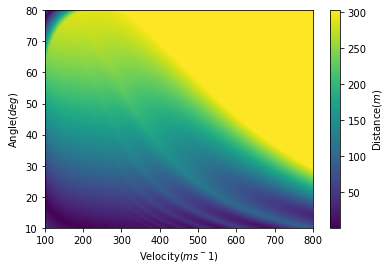

Image saved to "objective.pdf"


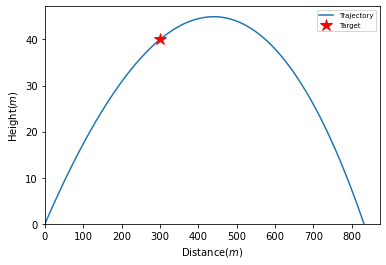

In [21]:
if __name__ == '__main__':

    doctest.testmod()

    while True:
        try:
            #Taking user inputs for target position
            tx = float(input('enter a downrange position: '))
            ty = float(input('enter a height: '))
            targ = (tx , ty)

            #Attempting optimization of initial projection conditions
            res = target((targ))


            if res[0]:          #Executing loop if optimization is successful
                print(' WE HIT THE TARGET! \nInitial Speed      :{:.2f}\nInitial Angle      :{:.2f}\nClosest Distance   :{:.3f}' .format(res[1] , res[2] , res[3]))

                #Generate objective image if user specifies
                y_n = 'nothing'
                while y_n != 'y':
                    y_n = input('generate Objective Image? [y/n]   ')
                    if y_n =='y':
                        objective_image(targ , (100,100))
                        print('Image saved to "objective.pdf"')
                        break
                    if y_n == 'n' or y_n =='':
                        break

                #Generate trajectory from optimized initial conditions and plot
                xy = solve_ode_scipy(res[1] , res[2] , 0 , 0.01)
                x = xy[:,3]
                y = xy[:,4]
                plt.plot(x , y , label='Trajectory')

                #Plot target position
                plt.plot(tx , ty , 'r*' , markersize=12 , label='Target')

                plt.xlim(0 , max(x)*1.05)
                plt.ylim(0 , max(y)*1.05)
                plt.legend(loc=1 , prop={'size':7})
                plt.xlabel('Distance' + r'($m$)')
                plt.ylabel('Height' + r'($m$)')
                plt.savefig('target.pdf')
                plt.show()

            else:
                print('Sorry your aim sucks! Target missed.')
            break

        except ValueError:
            print('Invalid target position entered. \nTarget coordinates must be positive numerical values.')
